# OSM Users / Aquitaine (Fr)

In [6]:
import math

In [7]:
import pandas as pd
import numpy as np

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:
sns.set_context('talk')

## Load data & transformation

* Lecture des données
* convertir les colonnes qui vont bien en date
* transformer les champs timedelta en nb de jours

In [11]:
fname = "./aquitaine-md-users.csv"

In [12]:
# total number of changeset by user (planet osm full history)
changeset_user_hist_fname = "./all-users-count-changesets.csv"

In [13]:
# index of the date-type columns
FIRST_AT = 20
LAST_AT = 21
EXTRACTION_DATE = pd.Timestamp('2017-03-23')

In [9]:
users = pd.read_csv(fname,
                    index_col=0,
                    parse_dates=[FIRST_AT, LAST_AT])
users.shape

IOError: File ./aquitaine-md-users.csv does not exist

In [290]:
# Should drop the raw with the uid=0 because it does not exist
users = users.query("uid != 0")
users.shape

(6064, 61)

In [291]:
# total nb of changesets by user (planet osm full history)
changeset_count_users = pd.read_csv(changeset_user_hist_fname,
                                    header=None,
                                    names=['uid', 'num'])

In [292]:
# changeset_count_users.head()
changeset_count_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839769 entries, 0 to 839768
Data columns (total 2 columns):
uid    839769 non-null int64
num    839769 non-null int64
dtypes: int64(2)
memory usage: 12.8 MB


In [293]:
# add the column n_total_chgset for each user in the 'users' DataFrame
#users.join?
users = (users.join(changeset_count_users.set_index('uid'), on='uid')
      .rename_axis({'num': 'n_total_chgset'}, axis=1))

In [294]:
# You don't have to have a null, i.e. NaN, value
assert users.n_total_chgset.isnull().sum() == 0

In [295]:
users.head()

,uid,n_chgset,n_modif_bychgset,nmax_modif_bychgset,n_elem_bychgset,nmax_elem_bychgset,meantime_between_chgset,n_modif,n_nodemodif,n_waymodif,...,n_relation_crupd,n_elem_crmod,n_node_crmod,n_way_crmod,n_relation_crmod,n_elem_crdel,n_node_crdel,n_way_crdel,n_relation_crdel,n_total_chgset
1,94,1,1.0,1,1.0,1,0 days 00:00:00.000000000,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1326
2,143,1,264.0,264,264.0,264,0 days 00:00:00.000000000,264,233.0,31.0,...,0.0,202.0,184.0,18.0,0.0,20.0,19.0,1.0,0.0,1070
3,165,11,1.0,10,1.0,10,181 days 06:17:58.500000000,20,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9007
4,246,6,1.0,3,1.0,1,118 days 03:08:55.000000000,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8922
5,356,9,25.0,941,25.0,941,116 days 03:03:33.750000000,1183,1077.0,104.0,...,0.0,32.0,18.0,14.0,0.0,25.0,19.0,6.0,0.0,562


In [296]:
# add the column 'how_long': extraction date - first_at
users['how_long'] = EXTRACTION_DATE - users['first_at']

In [297]:
# columns with a timedelta
dt_columns = ['meantime_between_chgset',
              'activity',
              'update_medtime',
              'corr_medtime',
              'autocorr_medtime',
              'how_long']

In [298]:
# columns with a timestamp
ts_columns = ['first_at', 'last_at']

In [299]:
# Turn all timedelta colums into real pd.Timedelta object, then retrieve the number of days
# dayfunc = lambda x: pd.Timedelta(x).days
for col in dt_columns:
    print(col)
    users[col] = users[col].apply(pd.Timedelta) / np.timedelta64(1, 'D')

meantime_between_chgset
activity
update_medtime
corr_medtime
autocorr_medtime
how_long


In [300]:
# Check if you have day values (in float)
users[dt_columns].head(3)

,meantime_between_chgset,activity,update_medtime,corr_medtime,autocorr_medtime,how_long
1,0.000000,0.000000,1458.038796,1458.038796,0.000000,4357.383889
2,0.000000,0.005949,508.023403,508.023403,0.000000,3174.032488
3,181.262483,1812.624850,1.966591,2.314896,0.498356,1850.145370


In [301]:
users[dt_columns].describe()

,meantime_between_chgset,activity,update_medtime,corr_medtime,autocorr_medtime,how_long
count,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000,6064.000000
mean,40.977572,272.187202,184.246428,230.415643,6.593759,1364.637960
std,137.420700,572.928689,298.874919,328.909611,53.994305,863.011959
min,0.000000,0.000000,0.000000,0.000000,0.000000,31.332234
25%,0.000000,0.000012,1.004442,3.808889,0.000000,660.520648
50%,0.031338,0.087367,35.257274,79.672075,0.000000,1292.980943
75%,15.081934,221.954280,253.336962,341.596920,0.014622,1923.361991
max,2531.057014,3879.761921,2949.025023,2949.025023,1357.934468,4357.383889


In [20]:
# users.info()

In [302]:
# Check if you don't have an 'object' type in your DataFrame
assert np.sum(users.dtypes.apply(str) == 'object') == 0

## Dig Deeper

In [303]:
# Drop the columns with dates
# Only keep the int & float data
dusers = users.drop(ts_columns, axis=1)

In [325]:
# some stats sorted by descending standard deviation
user_stat = dusers.drop('uid', axis=1).describe().T.sort_values(by='std', ascending=False)
user_stat = user_stat.drop('count', axis=1)
user_stat['qrange'] = user_stat['75%'] - user_stat['25%']
user_stat[['mean', '50%', 'std', 'qrange', 'min', 'max']]

,mean,50%,std,qrange,min,max
n_modif,5615.117909,15.000000,71668.275940,132.000000,1.000000,3.658020e+06
n_elem,5255.141326,12.000000,68226.427192,121.000000,1.000000,3.508659e+06
n_elem_cr,4652.566293,4.000000,62212.211557,71.000000,0.000000,3.186485e+06
n_nodemodif,4762.350923,8.000000,61103.221825,103.000000,0.000000,3.093087e+06
n_elem_lastupd,4314.361313,4.000000,58964.434027,59.000000,0.000000,3.002972e+06
n_node,4489.855046,8.000000,58461.410918,98.000000,0.000000,2.977939e+06
n_elem_crupd,3933.805079,1.000000,55607.914182,39.000000,0.000000,2.890456e+06
n_node_cr,4038.940303,3.000000,53240.094917,63.000000,0.000000,2.683380e+06
n_node_lastupd,3732.392810,3.000000,50763.939885,49.000000,0.000000,2.535201e+06
n_node_crupd,3462.200528,1.000000,47957.585706,36.000000,0.000000,2.440816e+06


### Corrélation

In [305]:
# without the uid
rho = dusers.drop('uid', axis=1).corr()
rho.shape

(60, 60)

In [306]:
rho.iloc[:8, :8]

,n_chgset,n_modif_bychgset,nmax_modif_bychgset,n_elem_bychgset,nmax_elem_bychgset,meantime_between_chgset,n_modif,n_nodemodif
n_chgset,1.000000,0.000201,0.358337,0.000407,0.354871,-0.028052,0.579601,0.585754
n_modif_bychgset,0.000201,1.000000,0.265225,0.997879,0.262164,-0.013422,0.083414,0.081668
nmax_modif_bychgset,0.358337,0.265225,1.000000,0.262972,0.998311,-0.021817,0.602428,0.593708
n_elem_bychgset,0.000407,0.997879,0.262972,1.000000,0.262592,-0.012919,0.083562,0.081760
nmax_elem_bychgset,0.354871,0.262164,0.998311,0.262592,1.000000,-0.022128,0.602019,0.593193
meantime_between_chgset,-0.028052,-0.013422,-0.021817,-0.012919,-0.022128,1.000000,-0.019483,-0.019393
n_modif,0.579601,0.083414,0.602428,0.083562,0.602019,-0.019483,1.000000,0.998253
n_nodemodif,0.585754,0.081668,0.593708,0.081760,0.593193,-0.019393,0.998253,1.000000


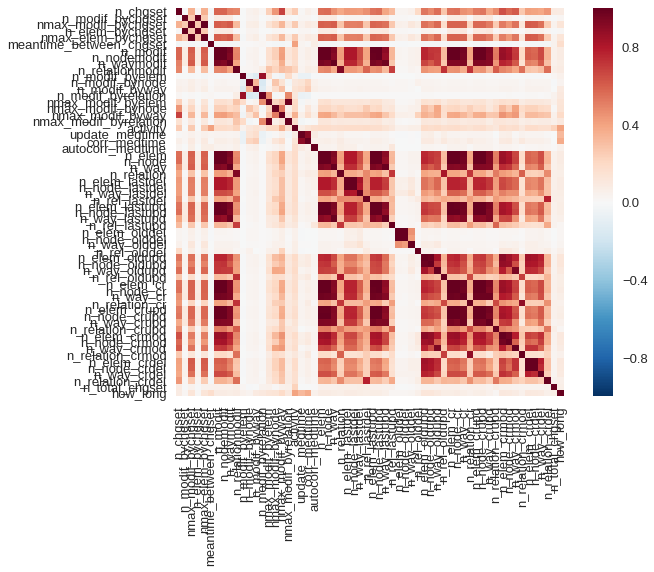

In [307]:
sns.heatmap(rho, square=True)

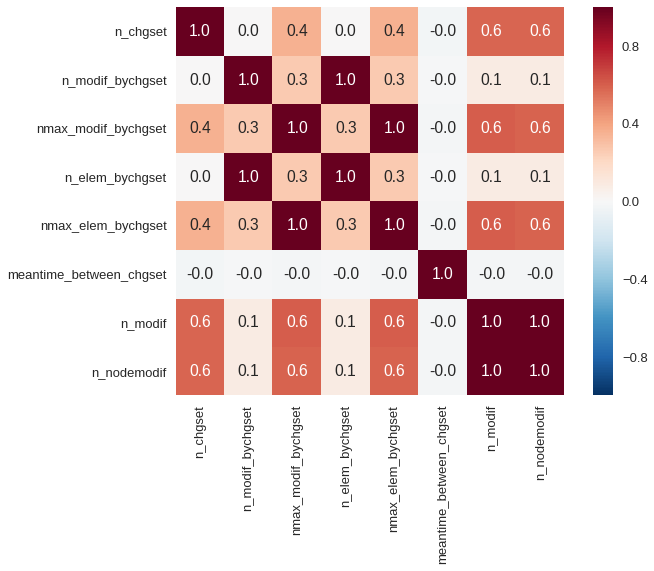

In [26]:
sns.heatmap(rho.iloc[:8, :8], square=True, annot=True, fmt='.1f')

### Features Functions

Some fonctions which can help to select / remove some features before computing a KMeans or a PCA and which carry out data normalization.

In [308]:
def init_features():
    "features without modif"
    return dusers.drop('uid', axis=1).copy()

In [309]:
def naive_norm(data):
    """Naive data normalization
    """
    return (data - data.mean()) / data.std()

In [310]:
def naive_median_norm(data):
    "Naive data normalization with median"
    return (data - data.median()) / data.std()

In [311]:
def robust_norm(data):
    """Robust scale for normalization
    
    fit well with outliers
    
    Kind of (data - median) / (range 75 - 25 quantiles)
    """
    scaler = RobustScaler()
    result = scaler.fit_transform(data)
    return pd.DataFrame(result, columns=data.columns)

In [313]:
def discard_cols(data, name):
    "Discard some cols with 'name' in it"
    col = [col for col in data.columns if name in col]
    return data.drop(col, axis=1).copy()

In [28]:
# discard '*node*' cols
discard_node_col = lambda x: discard_cols(x, 'node')
# discard '_elem' cols
discard_elem_col = lambda x: discard_cols(x, '_elem')

In [29]:
def add_changeset_ratio(data):
    "add number of changeset / total changeset ratio"
    result = data.copy()
    data['n_chgset_ratio'] = data['n_chgset'] / data['n_total_chgset']
    return data

In [30]:
# features["del_ratio"] = features.n_elem_lastdel / features.n_elem

### PCA

In [31]:
def compute_pca(n_components, features):
    """compute pca and return scores and loadings
    
    features: DataFrame (should be normalized)
    
    Results
    
    pca: pca model
    scores: values in the reduced dimension space, aka z
    loadings: weights by features and component
    """
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(features.values)
    nc = pca.components_.shape[0]
    print("explained variance {}".format(100. * pca.explained_variance_ratio_))
    print("sum of explained variance {}".format(100. * pca.explained_variance_ratio_.sum()))
    pca_cols = ['PC' + str(i+1) for i in range(nc)]
    scores = pd.DataFrame(X, columns=pca_cols)
    loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=features.columns).T
    return pca, scores, loadings

In [32]:
def correlation_circle(loadings, scores, x_comp=0, y_comp=1, threshold=0.1, explained=None):
    """draw a correlation circle form PCA results
    
    loadings: DataFrame
       (n_features, n_components)
    scores: DataFrame
       (n_observation, n_features)
    """
    #plt.Circle((0, 0), radius=10, color='g', fill=False)
    circle = plt.Circle((0, 0), radius=1, color='grey', fill=False)
    fsize = min(plt.rcParams['figure.figsize'])
    fig, ax = plt.subplots(figsize=(fsize, fsize))
    #fig = plt.gcf()
    #fig.gca().add_artist(circle)
    ax.add_artist(circle)
    # Rescaling [-1, 1]
    scalex = 1.0 / (pcscores.iloc[:, x_comp].max() - pcscores.iloc[:, x_comp].min())
    scaley = 1.0 / (pcscores.iloc[:, x_comp].max() - pcscores.iloc[:, y_comp].min())
    score_x = pcscores.copy().iloc[:, x_comp] * scalex
    score_y = pcscores.copy().iloc[:, y_comp] * scaley
    plt.scatter(score_x, score_y, marker='.')
    # loop on each feature
    for name, feature in loadings.iterrows():
        x, y = feature.iloc[x_comp], feature.iloc[y_comp]
        # do not draw the arrow
        if math.sqrt(x ** 2 + y ** 2) < threshold:
            continue
        plt.arrow(0, 0, x, y, width=0.005, color='k', alpha=0.8)
        plt.annotate(name, xy=(x,y))
    # labels for x and y with (optional) explained variance for the components
    xl = 'PC_' + str(x_comp+1)
    yl = 'PC_' + str(y_comp+1)
    xl = xl if explained is None else xl + ' ({:.2f}%)'.format(100. * explained[x_comp])
    yl = yl if explained is None else yl + ' ({:.2f}%)'.format(100. * explained[y_comp])
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.xlim((-1.1, 1.1))
    plt.ylim((-1.1, 1.1))
    plt.title("correlation circle PCA ({}, {})".format(x_comp+1, y_comp+1))

In [326]:
features = init_features()
# init shape
features.shape

(6064, 60)

#### PCA mle

Just test the number of components taken by the 'mle' parameter

In [374]:
mle = PCA(n_components='mle', svd_solver='full')
XMLE = mle.fit_transform(norm_features)
XMLE.shape

(6064, 49)

In [373]:
100 * mle.explained_variance_ratio_

array([  6.01944477e+01,   2.82270595e+01,   5.77022424e+00,
         3.27467391e+00,   8.07409387e-01,   7.14803366e-01,
         4.15415402e-01,   2.15472930e-01,   1.59086179e-01,
         7.70689017e-02,   7.14717502e-02,   2.66124833e-02,
         1.58085323e-02,   8.03603867e-03,   5.87044401e-03,
         4.28560511e-03,   2.74469268e-03,   2.61940950e-03,
         1.75342985e-03,   1.54771008e-03,   1.18597490e-03,
         6.48880296e-04,   6.02788350e-04,   4.42372485e-04,
         2.75134231e-04,   1.76529595e-04,   1.45338456e-04,
         3.83099962e-05,   3.49914733e-05,   1.13026734e-05,
         7.20105200e-06,   6.27606328e-06,   4.47380314e-06,
         2.75526688e-06,   1.91523553e-06,   1.23343928e-06,
         8.63187973e-07,   6.57305298e-07,   4.17391730e-07,
         3.87307931e-07,   3.01484943e-07,   1.96478108e-07,
         1.41934450e-08,   6.85554137e-27,   1.52757455e-27,
         6.81135516e-28,   1.77916391e-28,   9.07727018e-30,
         1.68944525e-30]

In [378]:
#sns.heatmap(mle.components_.T)

In [375]:
km_mle = KMeans(n_clusters=5)
K_MLE = km_mle.fit_transform(XMLE)

In [376]:
km_mle.inertia_

54179870215.967033

In [379]:
dusers.groupby(km_mle.labels_)['n_chgset'].agg(['median', 'count']).sort_values(by="median")

,median,count
0,2.0,5985
2,8.0,45
3,837.5,10
4,885.0,23
1,3771.0,1


#### PCA classic

Also, we removed some features.

In [221]:
# discard columnus with 'node'
features = discard_node_col(features)
features.shape

(6064, 47)

In [329]:
features = add_changeset_ratio(features)
features.shape

(6064, 50)

In [328]:
# try to drop all '*_elem' columns which are the sum of node + way + relation
features = discard_elem_col(features)
features.shape

(6064, 49)

In [224]:
# discard the col 'autocorr_medtime'
features = discard_cols(features, 'autocorr_medtime')
features.shape

(6064, 36)

In [94]:
#features.del_ratio.describe()

In [330]:
# Normalize the features
#norm = lambda x: (x - x.mean()) / x.std()
#norm_features = naive_norm(features)
#norm_features = naive_median_norm(features)
norm_features = robust_norm(features)

In [331]:
#norm_features.describe().T

In [332]:
pca, pcscores, loadings = compute_pca(5, norm_features)

explained variance [ 60.19444775  28.22705952   5.77022424   3.27467391   0.80740939]
sum of explained variance 98.27381481165047


In [135]:
#N_COMPONENTS = 5

In [205]:
#pca = PCA(n_components=N_COMPONENTS)
#X = pca.fit(norm_features).transform(norm_features)
#print("explained variance {}".format(100. * pca.explained_variance_ratio_))
#print("sum of explained variance {}".format(100. * pca.explained_variance_ratio_.sum()))

In [206]:
# Columns for the PCA
#pca_cols = ['PC' + str(i+1) for i in range(N_COMPONENTS)]

In [138]:
# pca scores in a DataFrame
#pcscores = pd.DataFrame(X, columns=pca_cols)

In [207]:
print("shape : {}".format(pcscores.shape))
pcscores.head()

shape : (6064, 5)


,PC1,PC2,PC3,PC4,PC5
0,-326.212232,-421.959216,-42.045986,-9.846332,-10.597466
1,-323.470385,-422.223291,-31.234836,-10.333276,-7.979472
2,-322.560535,-388.056402,-41.548190,-8.967629,-10.197620
3,-326.071115,-421.412394,-41.673152,-9.813349,-10.009109
4,-319.143512,-422.614139,-27.756610,-6.368707,-11.429725


In [140]:
# PCA components aka loadings in a dataframe
#loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=features.columns).T

In [208]:
print('shape: {}'.format(loadings.shape))
loadings.tail()
loadings.head()

shape: (37, 5)


,PC1,PC2,PC3,PC4,PC5
n_chgset,0.003135,-0.000195,0.020025,0.000927,0.006089
n_modif_bychgset,0.001160,-0.000178,-0.002558,-0.000270,-0.002842
nmax_modif_bychgset,0.007578,0.000119,0.025895,0.011009,0.022152
meantime_between_chgset,-0.000020,0.000191,-0.000111,-0.000065,-0.000102
n_modif,0.111952,-0.009978,0.174584,0.005507,0.102683


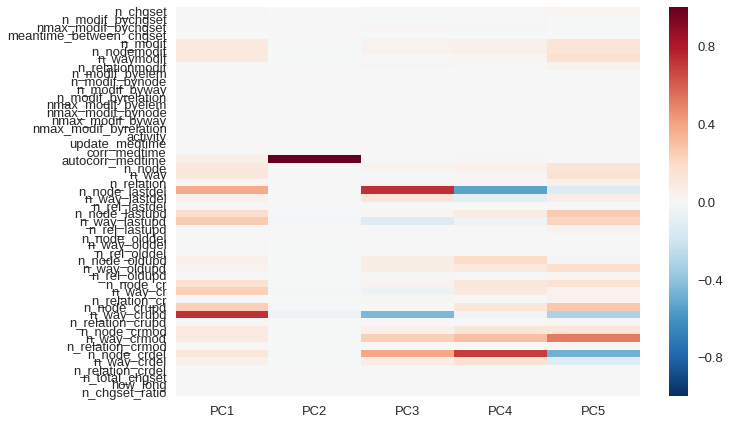

In [333]:
sns.heatmap(loadings)
# also try
# sns.heatmap(loadings ** 2)

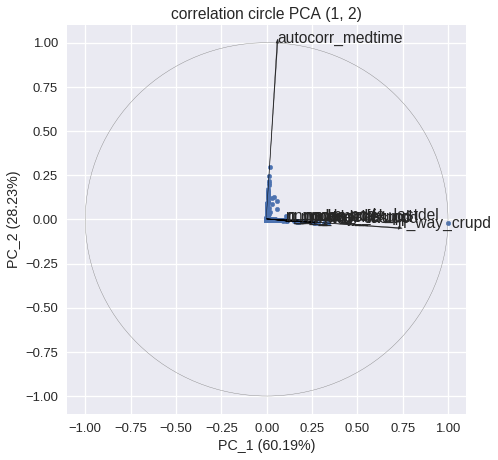

In [334]:
correlation_circle(loadings, pcscores, 0, 1, explained=pca.explained_variance_ratio_)

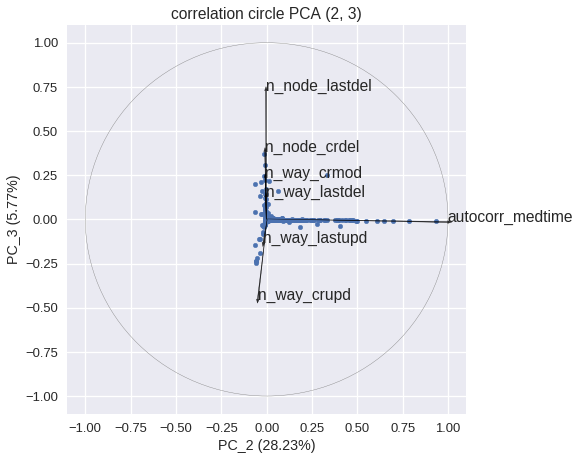

In [335]:
correlation_circle(loadings, pcscores, 1, 2, explained=pca.explained_variance_ratio_)

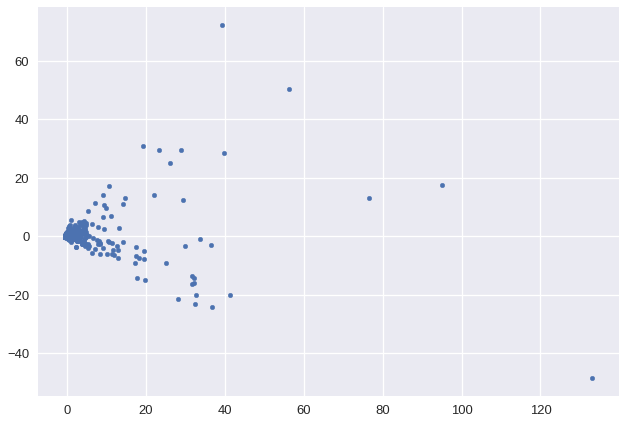

In [101]:
# 1st and 2nd
plt.scatter(pcscores.iloc[:, 0], pcscores.iloc[:, 1], marker='.')

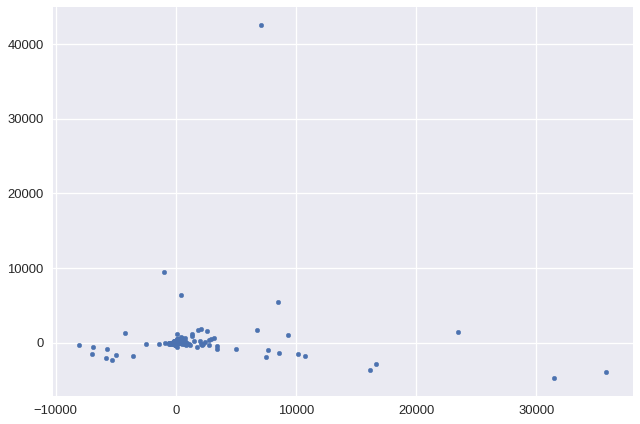

In [81]:
plt.scatter(pcscores.iloc[:, 1], pcscores.iloc[:, 2], marker='.')

### KMeans on PCA scores

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

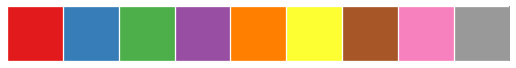

In [83]:
# choose a color palette for each label
# according to 'N_COMPONENTS' of course
sns.choose_colorbrewer_palette('qualitative')

In [336]:
#N_CLUSTERS = N_COMPONENTS
N_CLUSTERS = 5
#km = KMeans(n_clusters=N_COMPONENTS)
km = KMeans(n_clusters=N_CLUSTERS)

In [337]:
K = km.fit_transform(pcscores)

In [338]:
#k_means_cluster_centers = np.sort(km.cluster_centers_, axis=0)
#k_means_labels = pairwise_distances_argmin(pcscores.values, k_means_cluster_centers)

In [339]:
#k_means_labels
km.cluster_centers_.shape
#km.labels_.shape

(5, 5)

In [340]:
km.inertia_

49670016548.189568

In [341]:
km.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

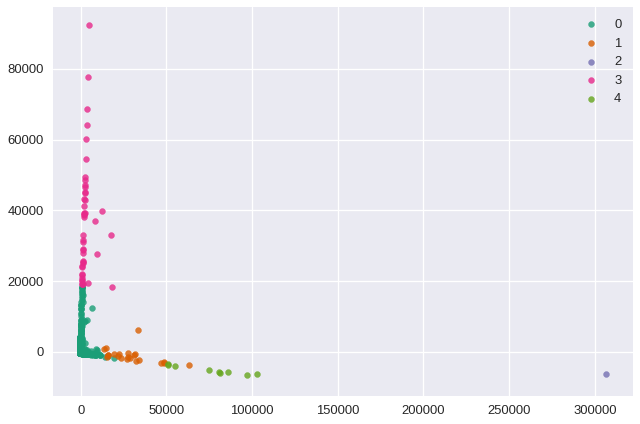

In [342]:
# try to plot some PCA scatter plot with a color for each labels found by the KMean
xdim, ydim = 0, 1
for label, color in zip(range(N_CLUSTERS), sns.color_palette('Dark2', N_CLUSTERS)):
    mask = (label == km.labels_)
    plt.scatter(pcscores.iloc[mask, xdim], pcscores.iloc[mask, ydim],
                color=color,
                s=35,
                alpha=0.8,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)

In [356]:
# sort the group of cluster according to the median of n_chgset for each cluster
LABELS = ['beginner', 'regular', 'intermediate', 'expert', 'pro']
dfcluster = dusers.groupby(km.labels_)['n_chgset'].agg(['median', 'count']).sort_values(by="median")
# dfcluster['label'] = LABELS
dfcluster['n_ratio'] = 100. * dfcluster['count'] / dusers.shape[0]
dfcluster

,median,count,n_ratio
0,2,5987,98.730211
3,8,45,0.742084
1,863,22,0.362797
4,1002,9,0.148417
2,3771,1,0.016491


In [355]:
n_users = dusers.shape[0]
100. * dusers.query("n_chgset > 20").shape[0] / n_users

13.621372031662268

In [349]:
dusers.loc[km.labels_ == 0, cols].describe()

,n_chgset,n_total_chgset,activity,autocorr_medtime,n_elem_cr,n_elem_lastupd,n_elem_lastdel,n_way,n_way_cr,n_way_crupd,n_way_crmod
count,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000,5987.000000
mean,21.934692,1479.920160,258.811752,2.474954,1209.232504,1140.027727,101.053115,235.132788,136.023551,91.341907,33.010356
std,147.574695,6684.441962,556.043884,16.996769,9302.862597,9214.590921,1302.829533,3933.384912,1230.635270,946.396353,398.189146
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,54.000000,0.065833,0.000000,4.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,8.000000,762.000000,188.551053,0.012801,65.000000,55.000000,3.000000,16.000000,6.000000,2.000000,2.000000
max,4818.000000,277704.000000,3879.761921,275.982882,233268.000000,248545.000000,55814.000000,283883.000000,38917.000000,33599.000000,20540.000000


Split the first big label into 2 or 3 clusters

### Try to split the huge first cluster into 2 or 3 parts

In [357]:
kmsplit = KMeans(n_clusters=2)

In [358]:
sub_features = norm_features[km.labels_ == 0]

In [359]:
KS = kmsplit.fit_transform(sub_features)

In [360]:
kmsplit.inertia_

10512189523.917227

In [361]:
dusers[km.labels_ == 0].groupby(kmsplit.labels_)['n_chgset'].agg(['median', 'count'])

,median,count
0,2.0,5937
1,17.5,50


without the `autocorr_medtime`

In [362]:
KS2 = kmsplit.fit_transform(sub_features.drop('autocorr_medtime', axis=1))

In [363]:
dusers[km.labels_ == 0].groupby(kmsplit.labels_)['n_chgset'].agg(['median', 'count'])

,median,count
0,2,5954
1,241,33


without the `n_way_crupd`

In [380]:
KS3 = kmsplit.fit_transform(sub_features.drop('n_way_crupd', axis=1))

In [381]:
dusers[km.labels_ == 0].groupby(kmsplit.labels_)['n_chgset'].agg(['median', 'count'])

,median,count
0,2.0,5937
1,17.5,50


### Clustering with the data (instead of PCA)

In [119]:
kmfull = KMeans(n_clusters=5)

In [152]:
#KF = kmfull.fit_transform(features)
KF = kmfull.fit_transform(robust_scaler.fit_transform(features))

In [153]:
kmfull.inertia_

30464225813.763168

In [154]:
sf = pd.Series(kmfull.labels_)
sf.groupby(sf).count()

0    5981
1      13
2      22
3       1
4      47
dtype: int64

In [264]:
dusers.query("n_chgset <= 2").shape[0]

3067

In [258]:
n_total_contrib = dusers.shape[0]

In [263]:
2998 / n_total_contrib * 100.

49.43116240725474

In [261]:
n_total_contrib

6065

### KMeans with (1) PCA and (2) features selection

In [211]:
features = init_features()
features.shape

(6064, 59)

In [212]:
features = discard_node_col(features)
features = add_changeset_ratio(features)
features = discard_elem_col(features)
#features = discard_cols(features, 'n_modif')
features = discard_cols(features, 'autocorr_medtime')
features.shape

(6064, 36)

In [213]:
#norm_features = robust_norm(features)
norm_features = naive_norm(features)

In [238]:
pca, pcscores, loadings = compute_pca(10, norm_features)

explained variance [ 29.82278933   9.94864915   7.38219239   5.88669896   4.62758467
   4.17575621   3.74286286   3.44960108   3.05790955   3.02530299]
sum of explained variance 75.11934719553759


In [266]:
n_clusters = 5
km_pca = KMeans(n_clusters)
km_full = KMeans(n_clusters)

In [267]:
K1 = km_pca.fit_transform(pcscores)

In [268]:
K2 = km_full.fit_transform(norm_features)

In [269]:
dfcluster_1 = dusers.groupby(km_pca.labels_)['n_chgset'].agg(['median', 'count']).sort_values(by="median")
# dfcluster['label'] = LABELS
dfcluster_1['n_ratio'] = 100. * dfcluster_1['count'] / dusers.shape[0]
dfcluster_1

,median,count,n_ratio
0,2,6024,99.340369
4,71,6,0.098945
1,757,22,0.362797
2,1731,11,0.181398
3,3771,1,0.016491


In [181]:
dfcluster_2 = dusers.groupby(km_full.labels_)['n_chgset'].agg(['median', 'count']).sort_values(by="median")
# dfcluster['label'] = LABELS
dfcluster_2['n_ratio'] = 100. * dfcluster_2['count'] / dusers.shape[0]
dfcluster_2

,median,count,n_ratio
4,1,4,0.065963
0,2,6017,99.224934
2,325,7,0.115435
3,671,33,0.544195
1,4423,3,0.049472


In [418]:
# who is in cluster 3 in km_full and not in cluster 3 in km_pca????
set(dusers[km_full.labels_ == 3].uid).difference(set(dusers[km_pca.labels_ == 1].uid))

{148173}

In [419]:
dusers.query("uid == 148173")

,uid,n_chgset,n_modif_bychgset,nmax_modif_bychgset,n_elem_bychgset,nmax_elem_bychgset,meantime_between_chgset,n_modif,n_nodemodif,n_waymodif,...,n_relation_crupd,n_elem_crmod,n_node_crmod,n_way_crmod,n_relation_crmod,n_elem_crdel,n_node_crdel,n_way_crdel,n_relation_crdel,n_total_chgset
1248,148173,893,32.0,50000,32.0,50000,3.103317,448846,386433.0,62220.0,...,40.0,14985.0,11448.0,3519.0,18.0,32876.0,30010.0,2851.0,15.0,1575


In [404]:
# Check if the user in the last label is the same
dusers[km_pca.labels_ == 3].uid.values, dusers[km_full.labels_ == 1].uid.values

(array([10610]), array([10610]))

In [408]:
# check for the 2nd group (i.e. 49 people)
pd.DataFrame({"pca": dusers[km_pca.labels_ == 2].uid.values,
              "full": dusers[km_full.labels_ == 2].uid.values}).head()

,full,pca
0,2488,2488
1,5112,5112
2,6053,6053
3,6703,6703
4,7412,7412


### Get a look to the main PCA features

* `autocorr_medtime`: durée médiane pendant laquelle une modification reste valide avant d'être amendée par l'utilisateur
* `n_way_crupd`: nombre de ways créés par l'utilisateur et toujours dans leur version initiale
* `n_way_crmod`: nombre ways créés par l'utilisateur et modifiés depuis leur création

In [348]:
cols = ['n_chgset', 'n_total_chgset', 'activity', 'autocorr_medtime',
        'n_elem_cr', 'n_elem_lastupd', 'n_elem_lastdel',
        'n_way', 'n_way_cr', 'n_way_crupd', 'n_way_crmod']

In [48]:
# cluster 1
dusers[km_full.labels_ == 0][cols].describe()

,n_chgset,n_total_chgset,activity,autocorr_medtime,n_way,n_way_cr,n_way_crupd,n_way_crmod
count,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000
mean,25.769038,1490.015831,262.835158,2.334670,362.560407,251.933011,160.518747,67.749875
std,191.792849,6687.110168,563.740197,15.563654,4660.641370,2638.414682,1897.958855,1032.066875
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,54.000000,0.067315,0.000000,2.000000,0.000000,0.000000,0.000000
75%,8.000000,773.000000,195.069352,0.012940,16.000000,7.000000,2.000000,2.000000
max,7764.000000,277704.000000,3879.761921,256.451076,283883.000000,65960.000000,52092.000000,54721.000000


In [415]:
# cluster 2
dusers[km_full.labels_ == 2][cols].describe()

,n_chgset,n_total_chgset,autocorr_medtime,n_way,n_way_cr,n_way_crupd,n_way_crmod
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,62.489796,1738.387755,526.258052,1878.489796,1752.346939,1567.408163,130.142857
std,183.827265,3641.549229,243.819988,5892.457043,5747.894620,5359.612933,413.617678
min,2.000000,2.000000,270.576823,0.000000,0.000000,0.000000,0.000000
25%,5.000000,23.000000,323.642292,6.000000,1.000000,0.000000,0.000000
50%,8.000000,136.000000,468.982541,26.000000,16.000000,3.000000,6.000000
75%,39.000000,1181.000000,637.993600,98.000000,42.000000,23.000000,16.000000
max,982.000000,16541.000000,1357.934468,32112.000000,31405.000000,29775.000000,2414.000000


In [416]:
# cluster 3
dusers[km_full.labels_ == 3][cols].describe()

,n_chgset,n_total_chgset,autocorr_medtime,n_way,n_way_cr,n_way_crupd,n_way_crmod
count,16.000000,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000
mean,1738.000000,7374.500000,1.487015,122045.625000,110178.93750,94404.500000,13344.562500
std,2423.643978,8984.623999,2.005376,44928.248567,44324.47403,42431.020919,20877.907475
min,35.000000,228.000000,0.004549,56724.000000,53330.00000,38721.000000,380.000000
25%,590.000000,824.500000,0.053811,96823.250000,75336.00000,53114.250000,1675.250000
50%,947.500000,1524.000000,0.542202,116658.000000,100497.00000,88326.000000,3978.500000
75%,1484.250000,14349.000000,2.699280,154324.250000,154172.75000,137547.250000,9843.500000
max,9466.000000,25475.000000,7.066157,205865.000000,176360.00000,159866.000000,69010.000000


In [417]:
# cluster 4
dusers[km_full.labels_ == 1][cols]

,n_chgset,n_total_chgset,autocorr_medtime,n_way,n_way_cr,n_way_crupd,n_way_crmod
149,3771,4322,171.951042,528112.0,502192.0,448956.0,38791.0


What features implies this user is unique (in comparison with the 3rd cluster)

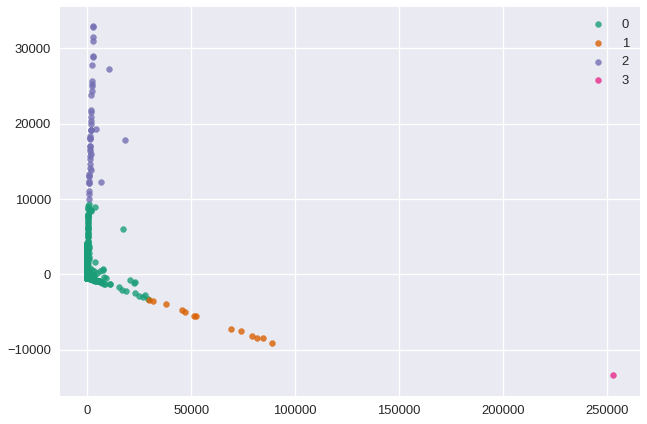

In [425]:
# try to plot some PCA scatter plot with a color for each labels found by the KMean
xdim, ydim = 0, 1
for label, color in zip(range(4), sns.color_palette('Dark2', 4)):
    mask = (label == km.labels_)
    plt.scatter(pcscores.iloc[mask, xdim], pcscores.iloc[mask, ydim],
                color=color,
                s=35,
                alpha=0.8,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)

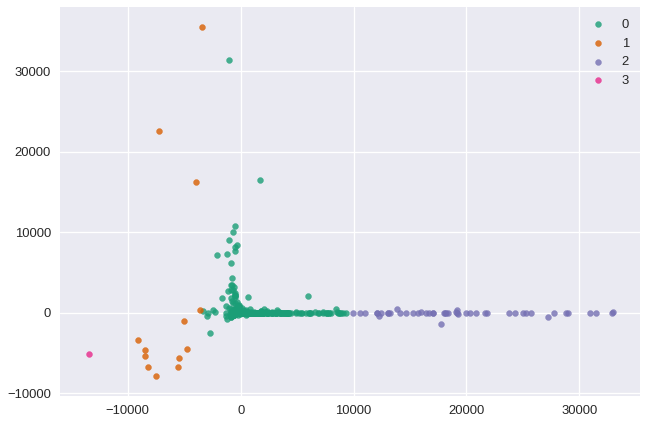

In [426]:
# try to plot some PCA scatter plot with a color for each labels found by the KMean
xdim, ydim = 1, 2
for label, color in zip(range(4), sns.color_palette('Dark2', 4)):
    mask = (label == km.labels_)
    plt.scatter(pcscores.iloc[mask, xdim], pcscores.iloc[mask, ydim],
                color=color,
                s=35,
                alpha=0.8,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)

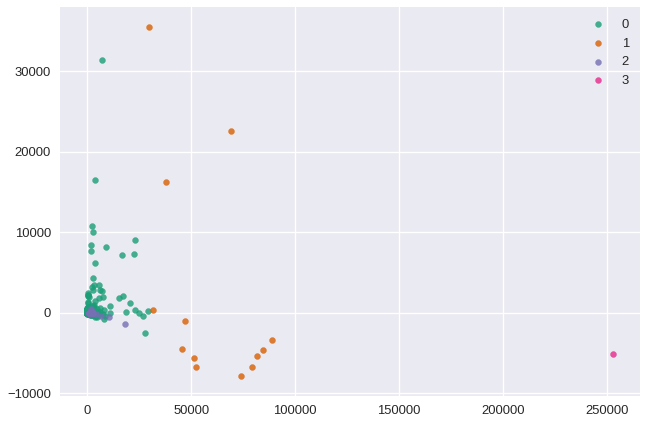

In [427]:
# try to plot some PCA scatter plot with a color for each labels found by the KMean
xdim, ydim = 0, 2
for label, color in zip(range(4), sns.color_palette('Dark2', 4)):
    mask = (label == km.labels_)
    plt.scatter(pcscores.iloc[mask, xdim], pcscores.iloc[mask, ydim],
                color=color,
                s=35,
                alpha=0.8,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)